# Behaviour Driving

The goal of this project is to teach a virtual vehicle to drive using only the driving data that we have collected in a simulator. This idea is most recently based on a paper by NVIDIA called [End To End Driving For Self-Driving Cars](https://arxiv.org/abs/1604.07316).

Useful Resources:
* [Steering Ratio](https://en.wikipedia.org/wiki/Steering_ratio)

## Loading The Dataset

In [287]:
# Visualizations will be shown in the notebook.
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2

In [288]:
path = '../datasets/behavioural_driving/Dataset_2'
img_path = path + '/IMG'
models_path = "./models"

In [289]:
data_csv = pd.read_csv(path + '/driving_log.csv', header=None, 
                       names = ["Center", "Left", "Right", "Steering Angle", "Throttle", "Brake","Speed"])
data_csv.head(n=10)

,Center,Left,Right,Steering Angle,Throttle,Brake,Speed
0,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.044182,0.987830,0,8.765856
1,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.098663,0.979730,0,10.083110
2,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.186713,0.975661,0,10.936000
3,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.186713,0.975661,0,12.136570
4,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.186713,0.975661,0,12.764350
5,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.186713,0.975661,0,13.870710
6,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.186713,0.975661,0,14.973310
7,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.174129,0.975661,0,16.186890
8,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.174129,0.975661,0,17.160210
9,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.174129,0.975661,0,18.380120


In [290]:
img_count = data_csv.shape[0]
print("Dataset counts {0} rows".format(img_count))

Dataset counts 2940 rows


## Investigation distribution of stearing angles

In [307]:
st_angles = np.asarray(data_csv["Steering Angle"], dtype=np.float32)

(array([  3.00000000e+00,   3.00000000e+00,   5.00000000e+00,
          1.90000000e+01,   1.30000000e+01,   5.10000000e+01,
          2.34000000e+02,   1.74000000e+02,   5.97000000e+02,
          1.66100000e+03,   5.10000000e+01,   2.70000000e+01,
          1.40000000e+01,   5.20000000e+01,   1.60000000e+01,
          9.00000000e+00,   1.00000000e+00,   9.00000000e+00,
          0.00000000e+00,   1.00000000e+00]),
 array([-0.61848682, -0.55370313, -0.48891944, -0.42413574, -0.35935205,
        -0.29456836, -0.22978467, -0.16500098, -0.10021728, -0.03543359,
         0.0293501 ,  0.09413379,  0.15891749,  0.22370118,  0.28848487,
         0.35326856,  0.41805226,  0.48283595,  0.54761964,  0.61240333,
         0.67718703]),
 <a list of 20 Patch objects>)

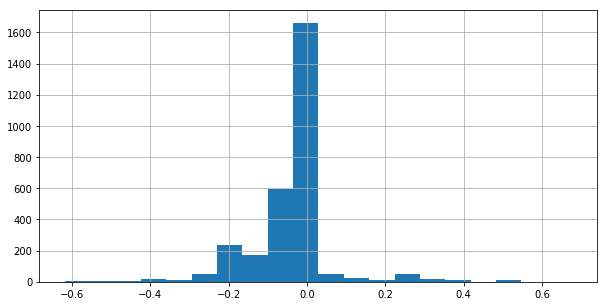

In [340]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.grid(True)
ax.hist(st_angles, bins=20, histtype='bar')

The dataset is greatly unbalanced, which means that **our model is biased towards turning left**. We must therefore find a way to equilibrate it.

## Load Images

In [342]:
def read_img(img_name, path):
    img_path = "{0}/{1}".format(path, img_name)
    img = cv2.imread(img_path)
    # Converting image to RGB
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Load Center Images And Flip Them

In [343]:
from imgaug import augmenters as iaa

In [447]:
# Crop the image in the hight dimension
crop_y_start = 60
new_y_max = 160 - crop_y_start 

In [448]:
X_train_center = np.zeros((img_count, new_y_max, 320, 3), dtype=np.uint8)
X_train_left = np.zeros((img_count, new_y_max, 320, 3), dtype=np.uint8)
X_train_right = np.zeros((img_count, new_y_max, 320, 3), dtype=np.uint8)

y_train_center = np.zeros((img_count), dtype=np.float32)
y_train_left = np.zeros((img_count), dtype=np.float32)
y_train_right = np.zeros((img_count), dtype=np.float32)

X_train_dict = {"Center": X_train_center, "Left": X_train_left, "Right": X_train_right}
y_train_dict = {"Center": y_train_center, "Left": y_train_left, "Right": y_train_right}

In [449]:
# Let's import all our images and steering angles
#X_train = np.zeros((img_count * 3, 160, 320, 3), dtype=np.uint8)
#y_train = np.zeros((img_count * 3), dtype=np.float32)

for index, row in data_csv.iterrows():
    #start_indx = index * 3
    
    for (i,pos) in enumerate([("Center", 0), ("Left", 0.30), ("Right", -0.25)]):
        pos_lb = pos[0]
        pos_angle_correction = pos[1]
        img = read_img(row[pos_lb].split("/")[-1], img_path)

        X_train_dict[pos_lb][index] = img[crop_y_start:,:,:]        
        y_train_dict[pos_lb][index] = row["Steering Angle"] + pos_angle_correction
    #center_img_path = "{0}/{1}".format(img_path,row["Center"].split("/")[-1])
    #print(center_img_path)
    # OpenCV returns Height x Width x RGB
    #img = cv2.imread(center_img_path)
    #X_train[index] = img
    #y_train[index] = row["Steering Angle"]

In [345]:
print("Shape of training set images: {0}\nShape of training set labels: {1}".format(X_train.shape, y_train.shape))

Shape of training set images: (8820, 160, 320, 3)
Shape of training set labels: (8820,)


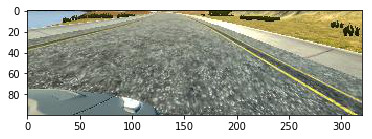

In [453]:
# Let's visualise an image
plt.imshow(X_train_right[976], cmap=None)
plt.show()

(array([  3.00000000e+00,   7.00000000e+00,   1.90000000e+01,
          2.40000000e+01,   8.10000000e+01,   3.22000000e+02,
          5.64000000e+02,   2.17500000e+03,   7.40000000e+02,
          2.10200000e+03,   7.58000000e+02,   1.73700000e+03,
          1.22000000e+02,   4.60000000e+01,   7.00000000e+01,
          2.30000000e+01,   1.50000000e+01,   6.00000000e+00,
          5.00000000e+00,   1.00000000e+00]),
 array([-0.7684868 , -0.68870311, -0.60891942, -0.52913573, -0.44935204,
        -0.36956835, -0.28978466, -0.21000097, -0.13021728, -0.05043359,
         0.0293501 ,  0.10913379,  0.18891748,  0.26870117,  0.34848486,
         0.42826855,  0.50805224,  0.58783593,  0.66761962,  0.74740331,
         0.827187  ]),
 <a list of 20 Patch objects>)

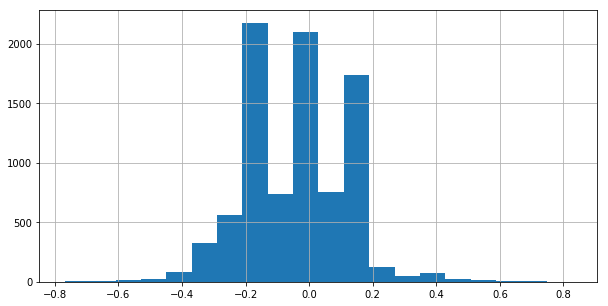

In [347]:
# Now let's see what our distribution of steering angles looks like
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.grid(True)
ax.hist(y_train, bins=20, histtype='bar')

## Build A Neural Net To Predict Steering Angles

We are using Keras, which in turn delegates to Tensorflow under the hood. Let's import all the functions we need.

In [348]:
# Initial Setup for Keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [349]:
# Let's also define the input shape
in_shape = (160, 320, 3)

### Simple Model

In this section we create a simple model to predict steering angles. There are no convolutions in this architecture, and since this is a pure _regression_ problem, and not a _classification_ one, we will be using the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) as the activation function in the last layer.

In [77]:
def simple_model():
    model = Sequential()
    model.add(Flatten(input_shape=in_shape))
    model.add(Dense(1))
    
    model.compile(loss = "MSE", optimizer = "adam", metrics=['accuracy'])
    return model

In [78]:
m = simple_model()
history = m.fit(X_train, y_train, nb_epoch=50, validation_split=0.2, shuffle=True, verbose=0)

In [66]:
# TODO PRINT ERROR IN FUTURE
print(history.history['val_acc'])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0047846889952153108, 0.0, 0.0095693779904306216, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0047846889952153108, 0.0, 0.0, 0.0, 0.0095693779904306216, 0.0047846889952153108, 0.0, 0.0, 0.0, 0.0, 0.0047846889952153108, 0.0047846890130396665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0047846889952153108, 0.0, 0.0, 0.0047846889952153108, 0.0047846889952153108]


In [80]:
# TODO PRINT ERROR IN FUTURE
print(history.history['val_loss'])

[21084.091385033946, 5162.5021910256091, 3336.7294165273065, 2661.4997425993411, 4334.0585921899956, 2931.8831720809203, 5767.068208054613, 2386.4748964157347, 1954.6100489217251, 6369.1227473542331, 1805.2955509466103, 8256.0578979882193, 1812.3054382519219, 1762.1040698164188, 1523.5546582499251, 1794.5441364129892, 2347.7099671775159, 3184.5184922873405, 1948.454331273088, 3321013.7428115015, 877065.70287539938, 60372.871655351439, 31081.517846445688, 63287.48497404153, 171630.6153154952, 309191.62914337061, 47877.987694688498, 283461.61861022364, 782862.09025559109, 492698.82547923323, 98549.914386980832, 85857.378344648561, 232147.39996006389, 902190.76996805111, 349112.241413738, 21909.791009384982, 181900.63064097444, 908597.79313099047, 760121.61281948886, 58112.869259185303, 194298.03783945687, 104528.26599940096, 5005818.2779552713, 36722.155975439295, 235452.51652356231, 141641.31055311501, 6716.3210254218247, 42497.774286142172, 125930.56150159745, 33481.090742312299]


In [81]:
m.save("{0}/simple_model.h5".format(models_path))

In [108]:
def plot_results(hist, metrics, xlb, ylb, title, leg, fsize = (10, 5)):
    fig, ax = plt.subplots(1, 1, figsize=fsize)
    for m in metrics:        
        ax.plot(hist.history[m])
    
    ax.set(xlabel=xlb, ylabel=ylb, title=title)
    ax.set_yscale('log')

    ax.legend(leg, loc='upper left')
    plt.show()

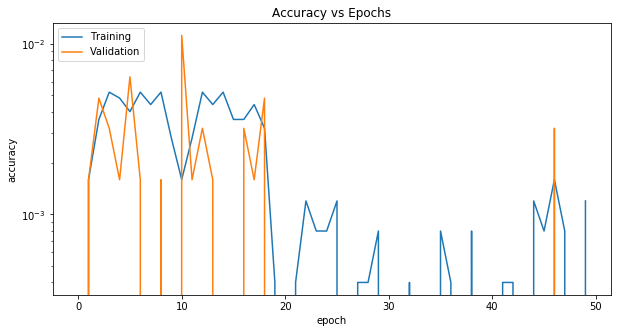

In [109]:
plot_results(history, ["acc", "val_acc"], "epoch", "accuracy", "Accuracy vs Epochs", ["Training", "Validation"])

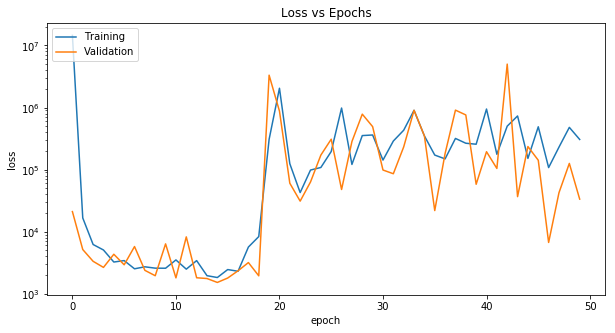

In [110]:
plot_results(history, ["loss", "val_loss"], "epoch", "loss", "Loss vs Epochs", ["Training", "Validation"])

We are not getting a stable network at all. The loss is erratic as well as the accuracy, and we are barely reaching 0.1% on the training set. We will explore next the architecture employed by the team from the NVIDIA paper.

## NVIDIA Model

### Pre-processing steps

In [381]:
mean_r = np.average(X_train[:,:,:,0])
mean_g = np.average(X_train[:,:,:,1])
mean_b = np.average(X_train[:,:,:,2])

In [382]:
mean_channels = [mean_r, mean_g, mean_b]
print("Mean for channels is {0}".format(mean_channels))

Mean for channels is [136.19009391165321, 142.25525395939627, 133.84246425028346]


### Creating our generator

Next we will create a Keras generator to return images in batches.

In [500]:
def fliph_image(img):
    """
    Returns a horizontally flipped image
    """
    return cv2.flip(img, 1)

In [ ]:
def change_image_lightness(img):
    # Convert to HSL
    # Add an offset to light component 
    # Convert back to RGB
    # Return image

In [504]:
def augment_image(img, st_angle, p=1.0):
    """
    Augment a given image with a probability p
    """
    aug_img = img
    
    # Try horizontal flip
    aug_img = fliph_image(img)
    st_angle = st_angle * (-1)
    
    # Try Changes in brightness
    
    # Try adding shadows
    
    return aug_img, st_angle

In [505]:
def generate_images(df, target_dimensions, batch_size=100, shuffle=True):
    """
    Generates images whose paths and steering angle are stored in supplied dataframe object df
    Returns the tuple (batch,steering_angles)
    """
    # e.g. 160x320x3 for target_dimensions
    batch = np.zeros((batch_size, target_dimensions[0],  target_dimensions[1],  target_dimensions[2]), dtype=np.float32)
    steering_angles = np.zeros(batch_size)
    df_len = len(df)
    img_types = ["Center", "Left", "Right"]
    st_angle_calibration = [0, 0.25, -0.25]
    
    while True:
        idx = np.random.randint(0, df_len, size=batch_size)       
        for b_i, i in enumerate(idx):
            row = df.iloc[i]
            st_angle = row["Steering Angle"]
            img_type_idx = np.random.randint(0, 3)
            img_type = img_types[img_type_idx]
            img_type_path = row[img_type]
            # Calibrate the steering angle accordingly
            st_angle += st_angle_calibration[img_type_idx]
            
            # Load image
            img = read_img(img_type_path.split("/")[-1], img_path)
            
            # Augment the image
            img, st_angle = augment_image(img, st_angle, 1.0)

            # Add our augmented image to our batch
            batch[b_i] = img
            steering_angles[b_i] = st_angle

        yield batch, steering_angles                                    

In [460]:
def crop(imgs):
    return imgs[:,crop_y_start:,:,:]

In [461]:
def resize(img):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(img, [66, 200])

In [462]:
def normalize_mean_channels(img):
    return img - [136.19009391165321, 142.25525395939627, 133.84246425028346]

In [536]:
def nvidia_model(target_shape, crop_y_start):
    model = Sequential()
    model.add(Lambda(lambda imgs: imgs[:,60:,:,:], input_shape=(160, 320, 3)))
#    model.add(Lambda(normalize_mean_channels))
    model.add(Lambda(resize))
    
    # TODO use Keras.Cropping instead of a lambda layer

    # We have a series of 3 5x5 convolutional layers with a stride of 2x2
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))

    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))    

    
    # This is then followed by 2 3x3 convolutional layers with a 1x1 stride
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='relu')) 

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='relu')) 

    model.add(BatchNormalization())
    
    # Flattening the output of last convolutional layer before entering fully connected phase
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(1164, activation='relu'))

    model.add(Dense(100, activation='relu'))

    model.add(Dense(50, activation='relu'))

    model.add(Dense(10, activation='relu'))

    
    # Output layer
    model.add(Dense(1))
    
    model.compile(loss = "MSE", optimizer = "adam")
    return model 

In [406]:
def normalise_images(imgs):
    return (imgs/255) - 0.5

In [478]:
X_train.shape

(8820, 160, 320, 3)

In [408]:
X_train = X_train.astype(np.float32)
#datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# Pre-compute mean, std, etc/
#datagen.fit(X_train)

In [537]:
t_shape = (66,200,3)
m = nvidia_model(t_shape, crop_y_start)

In [538]:
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_54 (Lambda)               (None, 100, 320, 3)   0           lambda_input_49[0][0]            
____________________________________________________________________________________________________
lambda_55 (Lambda)               (None, 66, 200, 3)    0           lambda_54[0][0]                  
____________________________________________________________________________________________________
convolution2d_151 (Convolution2D (None, 31, 98, 24)    1824        lambda_55[0][0]                  
____________________________________________________________________________________________________
convolution2d_152 (Convolution2D (None, 14, 47, 36)    21636       convolution2d_151[0][0]          
___________________________________________________________________________________________

In [520]:
b_size = len(data_csv) // 10
b_size

294

In [539]:
gen = generate_images(data_csv, (160, 320, 3), batch_size=b_size)

In [ ]:
m.fit_generator(gen, samples_per_epoch=len(data_csv) * 3, nb_epoch=5, verbose=1)

Epoch 1/5
8820/8820 [==============================] - 13s - loss: 0.0205    
Epoch 2/5
8820/8820 [==============================] - 13s - loss: 0.0101    
Epoch 3/5
3234/8820 [==========>...................] - ETA: 8s - loss: 0.0075

In [542]:
m.save("{0}/nivida_model_4.h5".format(models_path))

In [543]:
from keras.models import load_model,model_from_json

In [544]:
#m2 = load_model("{0}/nivida_model.h5".format(models_path), custom_objects={"tf": backend.tf})
m2 = load_model("{0}/nivida_model_4.h5".format(models_path))

In [261]:
m.to_json()

'{"keras_version": "1.2.1", "config": [{"config": {"batch_input_shape": [null, 160, 320, 3], "arguments": {}, "trainable": true, "output_shape": null, "output_shape_type": "raw", "function": ["\\u00e3\\u0001\\u0000\\u0000\\u0000\\u0000\\u0000\\u0000\\u0000\\u0002\\u0000\\u0000\\u0000\\u0004\\u0000\\u0000\\u0000C\\u0000\\u0000\\u0000s)\\u0000\\u0000\\u0000d\\u0001\\u0000d\\u0002\\u0000l\\u0000\\u0000m\\u0001\\u0000}\\u0001\\u0000\\u0001|\\u0001\\u0000j\\u0002\\u0000j\\u0003\\u0000|\\u0000\\u0000d\\u0003\\u0000d\\u0004\\u0000g\\u0002\\u0000\\u0083\\u0002\\u0000S)\\u0005N\\u00e9\\u0000\\u0000\\u0000\\u0000)\\u0001\\u00da\\u0002tf\\u00e9B\\u0000\\u0000\\u0000\\u00e9\\u00c8\\u0000\\u0000\\u0000)\\u0004\\u00da\\rkeras.backendr\\u0002\\u0000\\u0000\\u0000\\u00da\\u0005image\\u00da\\rresize_images)\\u0002\\u00da\\u0003img\\u00da\\u0003ktf\\u00a9\\u0000r\\n\\u0000\\u0000\\u0000\\u00fa <ipython-input-253-763cb1c42d3c>\\u00da\\u0006resize\\u0001\\u0000\\u0000\\u0000s\\u0004\\u0000\\u0000\\u0000\\

In [ ]:
model2 = model_from_json(m.to_json(), custom_objects={"ktf.image.resize_images": ktf.image.resize_images})